In [1]:
!pip install -q gradio sentence-transformers transformers torch pandas matplotlib


In [15]:
import numpy as np


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
import gradio as gr



In [5]:
faq_df = pd.read_csv("customer_faq.csv")  # <-- your CSV file
faq_df.head()


,Question,Answer,Category
0,How do I reset my password?,Click 'Forgot Password' on the login page and ...,Account
1,How can I change my username?,Go to account settings and edit your username.,Account
2,How do I update my email address?,Navigate to profile settings and update your e...,Account
3,How do I deactivate my account?,Contact support to deactivate your account saf...,Account
4,How can I enable two-factor authentication?,Go to security settings and follow the 2FA set...,Account


In [6]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

intent_model = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

qa_model = pipeline(
    "question-answering",
    model="distilbert-base-cased-distilled-squad"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cuda:0


In [7]:
faq_embeddings = embed_model.encode(
    faq_df["Question"].tolist(),
    convert_to_tensor=True
)


In [8]:
query_logs = []

def log_query(question, answer, category):
    query_logs.append({
        "question": question,
        "answer": answer,
        "category": category
    })


In [9]:
labels = faq_df["Category"].unique().tolist()

def classify_intent(question):
    try:
        result = intent_model(question, labels)
        return result["labels"][0]
    except:
        return "Account"   # fallback


In [19]:
def get_answer(user_question):
    user_question_clean = user_question.strip().lower()

    # ✅ 1. EXACT MATCH (highest priority)
    for idx, q in enumerate(faq_df["Question"]):
        if user_question_clean == q.strip().lower():
            answer = faq_df.iloc[idx]["Answer"]
            category = faq_df.iloc[idx]["Category"]
            log_query(user_question, answer, category)
            return answer

    # 🔁 2. SEMANTIC MATCH (fallback)
    question_embedding = embed_model.encode(
        user_question, convert_to_tensor=True
    )

    category = classify_intent(user_question)
    subset_df = faq_df[faq_df["Category"] == category]

    if subset_df.empty:
        subset_df = faq_df

    subset_embeddings = embed_model.encode(
        subset_df["Question"].tolist(), convert_to_tensor=True
    )

    scores = util.cos_sim(question_embedding, subset_embeddings)
    top_idx = int(np.argmax(scores.cpu().numpy()))

    answer = subset_df.iloc[top_idx]["Answer"]
    category = subset_df.iloc[top_idx]["Category"]

    log_query(user_question, answer, category)
    return answer



In [20]:
def chatbot_ui(user_input):
    return get_answer(user_input)

interface = gr.Interface(
    fn=chatbot_ui,
    inputs=gr.Textbox(placeholder="Ask a question..."),
    outputs="text",
    title="AI Customer Support Chatbot",
    description="ML + NLP + Embeddings + QA"
)

interface.launch(debug=False)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f966e1a6555b8d72e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [21]:
def show_dashboard():
    if not query_logs:
        print("No queries logged yet.")
        return

    df = pd.DataFrame(query_logs)
    counts = df["category"].value_counts()

    counts.plot(kind="bar", title="Queries per Category")
    plt.show()


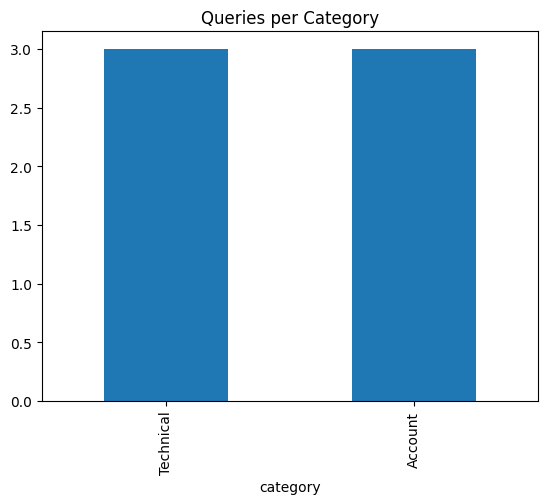

In [22]:
show_dashboard()
